# External data exploration

With this notebook we will analyze the two dataset of IMDB and TMDB. In particular from these datasets we are interested to gather the runtime of each film.

### Imports

In [1]:
import os

import pandas as pd
import numpy as np

from src.utils.const import DATA_DIR
from src.visualization.visualize import histplot
import warnings

In [2]:
warnings.filterwarnings("ignore", 'This pattern has match groups')

### Useful path to data

In [3]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
EXTERNAL_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'external')
INTERIM_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'interim')

## Imdb dataset

Title-basics is one of the many dataset that imdb let us available. As we said before, the only information that we take are the runtime and the tconst.

In [4]:
imdb = pd.read_csv(
    os.path.join(EXTERNAL_DIR, 'title-basics.csv'),
    encoding='utf-8',
    usecols=['tconst', 'runtimeMinutes'],
    dtype={'tconst': 'string'}
)

imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8867815 entries, 0 to 8867814
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          string
 1   runtimeMinutes  object
dtypes: object(1), string(1)
memory usage: 135.3+ MB


In [5]:
print(f'Tags dimensionality: {imdb.shape}')

Tags dimensionality: (8867815, 2)


The cardinality of this dataset is bigger than ours. From the imdb dataset we have the data of all the films that are stored inside imdb's database. For this reason, in the next steps we will let only the rows that represent a film of the movies dataset.

## IMDB pre-process

In [6]:
imdb.head(20)

,tconst,runtimeMinutes
0,tt0000001,1
1,tt0000002,5
2,tt0000003,4
3,tt0000004,12
4,tt0000005,1
5,tt0000006,1
6,tt0000007,1
7,tt0000008,1
8,tt0000009,40
9,tt0000010,1


We are now looking for all the rows that contains an invalid runtime in order to replace these values with NaN. For example, in the previous output we have at index 18, a runtimeMinutes that contains '\N'.

In [7]:
imdb[imdb['runtimeMinutes'].str.contains('([\\]*[a-zA-Z|\\-]+)')==True].shape

(6481648, 2)

Now we've founded a way to select these rows, we can replace these invalid values with NaN.

In [8]:
imdb = (imdb
        .replace(regex={'runtimeMinutes': '([\\]*[a-zA-Z|\\-]+)'}, value={'runtimeMinutes': np.nan})
        .rename(columns={'runtimeMinutes': 'runtime'})
        .astype({'runtime': 'float32'}))

imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8867815 entries, 0 to 8867814
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   tconst   string 
 1   runtime  float32
dtypes: float32(1), string(1)
memory usage: 101.5 MB


## TMDB dataset

In order to gather some information from tmdb, we made a query for each film of the movies dataset to the tmdb database through its API. We only downloaded the information about the films that are contained in the movies dataset. Since we are interested to know the run time of the film, we used only this feature plus the ones that are needed to identify the movie.

In [9]:
tmdb = pd.read_csv(
    os.path.join(EXTERNAL_DIR, 'tmdb.csv'),
    encoding='utf-8',
    usecols=['movieId', 'tmdbId', 'imdb_id', 'runtime'],
    dtype={'movieId': 'int32', 'imdb_id': 'string', 'tmdbId': 'float32', 'runtime': 'float32'}
)

tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  58098 non-null  int32  
 1   tmdbId   57917 non-null  float32
 2   runtime  57110 non-null  float32
 3   imdb_id  57156 non-null  string 
dtypes: float32(2), int32(1), string(1)
memory usage: 1.1 MB


## Removing the films that are not part of movies dataset

#### Merge TMDB and IMDB

Finally, we can throw away all the rows that doesn't regard our dataset. This is done merging the imdb dataset with the tmdb one, that contains only the rows that came from the movies dataset.

In [10]:
tmdb = tmdb.merge(imdb, how='left', left_on='imdb_id', right_on='tconst')

#### Choose a runtime that is not NaN or 0

Thanks to the fact that we have the runtimes from two different sources, after the merge this two dataset, we can choose the runtime that is not 0 or NaN.

In [11]:
def extract_correct_runtime(df: pd.DataFrame) -> pd.DataFrame:
    df['runtime'] = df['runtime_x'].mask((df['runtime_x'].isna()) | (df['runtime_x'] == 0), df['runtime_y'])
    return df

In [12]:
tmdb= tmdb.pipe(extract_correct_runtime)

#### Checking NaN values

In [13]:
tmdb[tmdb['runtime'].isna()].shape

(972, 7)

Since we still have some NaN values on the runtime feature, we need to understand with which values we can replace the NaN values.

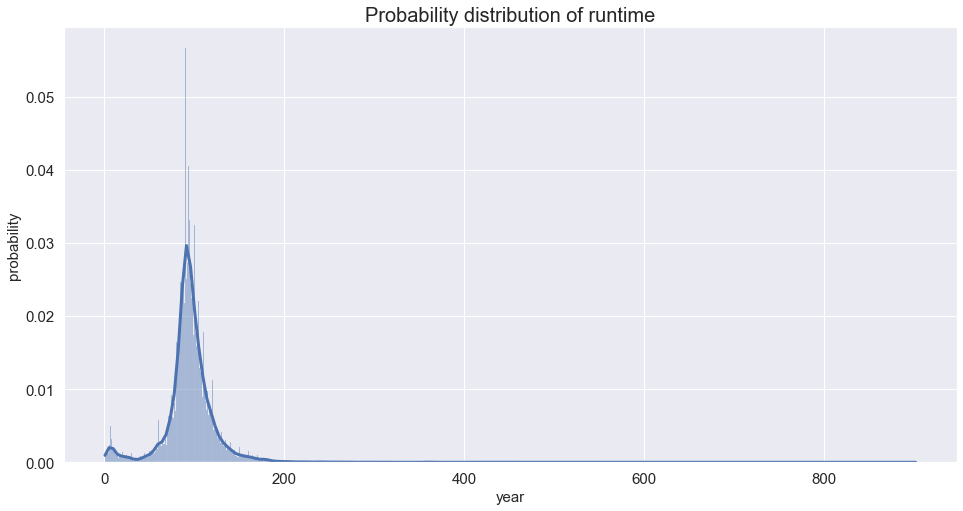

In [20]:


histplot(tmdb['runtime'],
         title='Probability distribution of runtime',
         xlabel='year',
         ylabel='probability',
         stat='probability',
         discrete=True,
         kde=True)

The runtime of the films has a skewed distribution. For this reason, we replace the NaN values with the median.

In [15]:
# Cleaning
tmdb = (tmdb
        .fillna({'runtime': tmdb['runtime'].median()})
        .drop(columns=['tmdbId', 'imdb_id', 'tconst', 'runtime_x', 'runtime_y']))

tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 0 to 58097
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  58098 non-null  int32  
 1   runtime  58098 non-null  float32
dtypes: float32(1), int32(1)
memory usage: 907.8 KB
